first we need to train a parametric-umap network for each dataset... (5 datasets x 2 dimensions)
For umap-learn, UMAP AE, Param. UMAP, PCA
- load dataset
- load network
- compute reconstruction MSE
- count time

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [4]:
import numpy as np
import pickle
import pandas as pd
import time
from umap import UMAP

In [5]:
from tfumap.umap import tfUMAP
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
from tqdm.autonotebook import tqdm

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [8]:
output_dir = MODEL_DIR/'projections' 

In [9]:
reconstruction_acc_df = pd.DataFrame(columns = ['method_', 'dimensions', 'dataset', 'MSE', 'MAE', 'MedAE', 'R2'])

In [10]:
reconstruction_speed_df = pd.DataFrame(columns = ['method_', 'dimensions', 'dataset', 'embed_time', 'recon_time', 'speed', 'nex'])

### MNIST

In [11]:
dataset = 'macosko2015'
dims = [50]

##### load dataset

In [12]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#dataset_address = 'http://file.biolab.si/opentsne/macosko_2015.pkl.gz'
# https://opentsne.readthedocs.io/en/latest/examples/01_simple_usage/01_simple_usage.html
# also see https://github.com/berenslab/rna-seq-tsne/blob/master/umi-datasets.ipynb

import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

print("Data set contains %d samples with %d features" % x.shape)

from sklearn.model_selection import train_test_split

def zero_one_norm(x):
    return (x- np.min(x, axis=0))/ (np.max(x, axis=0)-np.min(x, axis=0))

x_norm = zero_one_norm(x)

X_train, X_test, Y_train, Y_test = train_test_split(x_norm, y, test_size=.1, random_state=42)

np.shape(X_train)

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

X_train_flat = X_train

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()

X_train_flat = X_train
X_test_flat = X_test

Data set contains 44808 samples with 50 features


### AE 

##### 2 dims

In [13]:
load_loc = output_dir / dataset / 'autoencoder' 

In [14]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [15]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [16]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [17]:
X_recon = decoder(encoder(X_test)).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [18]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [19]:
import matplotlib.pyplot as plt

(array([1.2181e+04, 1.8812e+04, 2.2892e+04, 3.2167e+04, 5.7821e+04,
        4.0748e+04, 2.6636e+04, 1.2310e+04, 4.3300e+02, 5.0000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

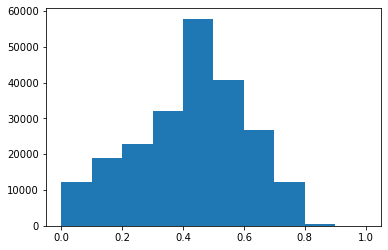

In [20]:
plt.hist(x_real.flatten())

(array([12108., 19567., 22025., 31418., 49460., 45352., 23244., 18269.,
         2543.,    64.]),
 array([0.01297177, 0.10760446, 0.20223716, 0.29686984, 0.39150256,
        0.48613524, 0.5807679 , 0.6754006 , 0.77003336, 0.86466604,
        0.95929873], dtype=float32),
 <a list of 10 Patch objects>)

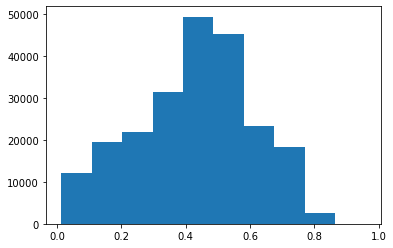

In [21]:
plt.hist(x_recon.flatten())

In [22]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['AE', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,macosko2015,0.000507,0.010176,0.005322,0.335652


##### 64 dims

In [23]:
load_loc = output_dir / dataset / '64' / 'autoencoder' 

In [24]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [25]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [26]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [27]:
X_recon = decoder(encoder(X_test)).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [28]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [29]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['AE', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,macosko2015,0.000507,0.010176,0.005322,0.335652
1,AE,64,macosko2015,0.000277,0.008203,0.004512,0.590031


### Network

##### 2 dims

In [30]:
load_loc = output_dir / dataset / 'recon-network' 

In [31]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "network",
    batch_size = 100,
    dims = dims
)

In [32]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [33]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [34]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = encoder(X_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = decoder(z_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    recon_time = end_time - start_time
    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "network",
        2,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.03618646110408008
seconds:  0.04024898796342313
seconds:  0.0025396929122507572
seconds:  0.002330527175217867
seconds:  0.0027018669061362743
seconds:  0.002642035949975252
seconds:  0.002559994114562869
seconds:  0.002158222021535039
seconds:  0.0024086888879537582
seconds:  0.0022805051412433386
seconds:  0.0021180210169404745
seconds:  0.0018064919859170914
seconds:  0.0019680268596857786
seconds:  0.0017694709822535515
seconds:  0.0020053479820489883
seconds:  0.0017461201641708612
seconds:  0.0018672640435397625
seconds:  0.0017474701162427664
seconds:  0.0019652261398732662
seconds:  0.0017809721175581217



In [35]:
with tf.device('/CPU:0'):
    n_repeats = 10
    for i in tqdm(range(n_repeats)):
        start_time = time.monotonic()
        z_test = encoder(X_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        embed_time = end_time - start_time

        start_time = time.monotonic()
        x_test_recon = decoder(z_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        recon_time = end_time - start_time
        reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
            "network-cpu",
            2,
            dataset,
            embed_time,
            recon_time,
            embed_time + recon_time,
        len(X_test_flat)
        ]

seconds:  0.058781731175258756
seconds:  0.038023473927751184
seconds:  0.004671395057812333
seconds:  0.005431426921859384
seconds:  0.004366555018350482
seconds:  0.004564551869407296
seconds:  0.004963553044945002
seconds:  0.005666533950716257
seconds:  0.0037285578437149525
seconds:  0.004377115983515978
seconds:  0.00455852085724473
seconds:  0.004160300130024552
seconds:  0.004150148946791887
seconds:  0.005470118019729853
seconds:  0.004200950963422656
seconds:  0.005120857153087854
seconds:  0.004572832025587559
seconds:  0.005430755903944373
seconds:  0.004802868003025651
seconds:  0.00406755693256855



In [36]:
X_recon = decoder(encoder(X_test)).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [37]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [38]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['network', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,macosko2015,0.000507,0.010176,0.005322,0.335652
1,AE,64,macosko2015,0.000277,0.008203,0.004512,0.590031
2,network,2,macosko2015,0.000799,0.011572,0.005110,0.154924


##### 64 dims

In [39]:
load_loc = output_dir / dataset / '64' / 'recon-network' 

In [40]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [41]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [42]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [43]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = encoder(X_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = decoder(z_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    recon_time = end_time - start_time
    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "network",
        64,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.03552028187550604
seconds:  0.03997276001609862
seconds:  0.002491131890565157
seconds:  0.002670216839760542
seconds:  0.0026426061522215605
seconds:  0.002147702034562826
seconds:  0.002161292126402259
seconds:  0.0022058039903640747
seconds:  0.0023094560019671917
seconds:  0.001699778949841857
seconds:  0.001887905178591609
seconds:  0.0017153688240796328
seconds:  0.0018584630452096462
seconds:  0.001945186872035265
seconds:  0.0018701939843595028
seconds:  0.0017744309734553099
seconds:  0.0017936117947101593
seconds:  0.0017714209388941526
seconds:  0.001785981934517622
seconds:  0.0017964409198611975



In [44]:
with tf.device("/CPU:0"):
    n_repeats = 10
    for i in tqdm(range(n_repeats)):
        start_time = time.monotonic()
        z_test = encoder(X_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        embed_time = end_time - start_time

        start_time = time.monotonic()
        x_test_recon = decoder(z_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        recon_time = end_time - start_time
        reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
            "network-cpu",
            64,
            dataset,
            embed_time,
            recon_time,
            embed_time + recon_time,
        len(X_test_flat)
        ]

seconds:  0.03012821706943214
seconds:  0.03654350200667977
seconds:  0.004542701179161668
seconds:  0.004259102046489716
seconds:  0.004174640867859125
seconds:  0.004026436014100909
seconds:  0.004350475035607815
seconds:  0.004652314120903611
seconds:  0.0044740778394043446
seconds:  0.004147728905081749
seconds:  0.004790588049218059
seconds:  0.00395063403993845
seconds:  0.003657305845990777
seconds:  0.004068447044119239
seconds:  0.003824500134214759
seconds:  0.0039324830286204815
seconds:  0.004074217984452844
seconds:  0.004188830964267254
seconds:  0.0037836190313100815
seconds:  0.004372966010123491



In [45]:
reconstruction_speed_df

,method_,dimensions,dataset,embed_time,recon_time,speed,nex
0,network,2,macosko2015,0.036186,0.040249,0.076435,4481
1,network,2,macosko2015,0.002540,0.002331,0.004870,4481
2,network,2,macosko2015,0.002702,0.002642,0.005344,4481
3,network,2,macosko2015,0.002560,0.002158,0.004718,4481
4,network,2,macosko2015,0.002409,0.002281,0.004689,4481
5,network,2,macosko2015,0.002118,0.001806,0.003925,4481
6,network,2,macosko2015,0.001968,0.001769,0.003737,4481
7,network,2,macosko2015,0.002005,0.001746,0.003751,4481
8,network,2,macosko2015,0.001867,0.001747,0.003615,4481
9,network,2,macosko2015,0.001965,0.001781,0.003746,4481


In [46]:
X_recon = decoder(encoder(X_test)).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [47]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [48]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['network', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,macosko2015,0.000507,0.010176,0.005322,0.335652
1,AE,64,macosko2015,0.000277,0.008203,0.004512,0.590031
2,network,2,macosko2015,0.000799,0.011572,0.005110,0.154924
3,network,64,macosko2015,0.000451,0.009078,0.004311,0.417873


#### UMAP-learn

##### 2 dims

In [49]:
embedder = UMAP(n_components = 2, verbose=True)
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sat Jul 18 11:07:38 2020 Finding Nearest Neighbors
Sat Jul 18 11:07:38 2020 Building RP forest with 14 trees
Sat Jul 18 11:07:39 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Sat Jul 18 11:07:48 2020 Finished Nearest Neighbor Search
Sat Jul 18 11:07:50 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jul 18 11:08:14 2020 Finished embedding


In [50]:
x_test_samples= []
x_test_recon_samples= []
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = embedder.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    embed_time = end_time - start_time

    nex = 10 # it would take far too long to reconstruct the entire dataset
    samp_idx = np.random.randint(len(z_test),  size= nex)
    sample = np.array(z_test)[samp_idx]
    x_test_samples.append(samp_idx)
    start_time = time.monotonic()
    x_test_recon = embedder.inverse_transform(sample);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    recon_time = (end_time - start_time)*len(z_test)/nex

    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "umap-learn",
        2,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]
    x_test_recon_samples.append(x_test_recon)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  16.077007019193843
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  32.93827842292376
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  4.931507837958634
	completed  0  /  

In [51]:
x_recon = np.concatenate(x_test_recon_samples)

In [52]:
x_real = np.array(X_test_flat)[np.concatenate(x_test_samples)]

In [53]:

MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['umap-learn', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,macosko2015,0.000507,0.010176,0.005322,0.335652
1,AE,64,macosko2015,0.000277,0.008203,0.004512,0.590031
2,network,2,macosko2015,0.000799,0.011572,0.005110,0.154924
3,network,64,macosko2015,0.000451,0.009078,0.004311,0.417873
4,umap-learn,2,macosko2015,0.000339,0.013422,0.011102,-1.009019


##### PCA

##### 2 dims


In [54]:
pca = PCA(n_components=2)
z = pca.fit_transform(X_train_flat)

In [55]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = pca.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = pca.inverse_transform(z_test);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    recon_time = (end_time - start_time)

    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "pca",
        2,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.000993059016764164
seconds:  0.00113176298327744
seconds:  0.00048239389434456825
seconds:  0.0013239390682429075
seconds:  0.0004580640234053135
seconds:  0.0010325598996132612
seconds:  0.00267716683447361
seconds:  0.0013587391003966331
seconds:  0.0004935238976031542
seconds:  0.0012710869777947664
seconds:  0.000490914098918438
seconds:  0.0009620878845453262
seconds:  0.0004870740231126547
seconds:  0.000856724800541997
seconds:  0.0004929350689053535
seconds:  0.0008604649920016527
seconds:  0.0004856339655816555
seconds:  0.0009556680452078581
seconds:  0.0005124250892549753
seconds:  0.0009185168892145157



In [56]:
X_recon = pca.inverse_transform(pca.transform(X_test_flat))
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['pca', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,macosko2015,0.000507,0.010176,0.005322,0.335652
1,AE,64,macosko2015,0.000277,0.008203,0.004512,0.590031
2,network,2,macosko2015,0.000799,0.011572,0.005110,0.154924
3,network,64,macosko2015,0.000451,0.009078,0.004311,0.417873
4,umap-learn,2,macosko2015,0.000339,0.013422,0.011102,-1.009019
5,pca,2,macosko2015,0.000974,0.012988,0.005960,0.039447


### Save

In [57]:
#save_loc = DATA_DIR / 'reconstruction_speed' / (dataset + '.pickle')
#ensure_dir(save_loc)
#reconstruction_speed_df.to_pickle(save_loc)

In [58]:
save_loc = DATA_DIR / 'reconstruction_acc' / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)